In [1]:

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
import lifetimes

In [3]:
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

In [4]:
# loading data 
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
product = pd.read_csv("olist_products_dataset.csv")
seller = pd.read_csv("olist_sellers_dataset.csv")
translate = pd.read_csv("product_category_name_translation.csv")


In [5]:
customers.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

In [6]:
orders = pd.merge(orders,customers[['customer_id','customer_unique_id']],on='customer_id')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [7]:
print(order_items.columns)

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


In [8]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [9]:
#keeping the first item from each order.
order_items.drop_duplicates('order_id',keep='first',inplace=True)


In [10]:
order_items.shape

(98666, 7)

In [11]:
#join orders with items to append price information
transaction_data = pd.merge(orders,order_items,'inner','order_id')
transaction_data = transaction_data[['customer_unique_id','order_purchase_timestamp','price']]

## convert timestamp to date; only need the day
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()


,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


In [12]:
# Lifetimes package has a function for converting transaction data into an RFM DataFrame.

rfm_summary= summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
rfm_summary.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


In [26]:
rfm_summary.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


In [13]:
rfm_summary[rfm_summary['frequency']>0].head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90


In [14]:
transaction_data[transaction_data['customer_unique_id']=='004b45ec5c64187465168251cd1c9c2f']

,customer_unique_id,price,date
44130,004b45ec5c64187465168251cd1c9c2f,59.9,2017-09-01
50843,004b45ec5c64187465168251cd1c9c2f,27.0,2018-05-26


In [15]:
rfm_summary['frequency'].value_counts()

0.0     93335
1.0      1927
2.0       126
3.0        18
4.0         6
5.0         5
6.0         2
15.0        1
Name: frequency, dtype: int64

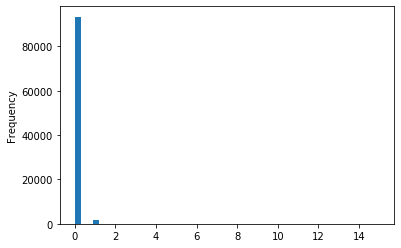

In [21]:
rfm_summary['frequency'].plot(kind='hist', bins=50)

In [22]:
one_time_buyers = round(sum(rfm_summary['frequency']==0)/float(len(rfm_summary))*(100),2)
print("Customers who purchase only once(%):", one_time_buyers, "%")

Customers who purchase only once(%): 97.81 %


In [23]:

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm_summary['frequency'], rfm_summary['recency'], rfm_summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

In [24]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.015627,0.000819,0.014021,0.017233
alpha,65.858911,6.194610,53.717476,78.000347
a,2.068727,0.494811,1.098898,3.038556
b,0.353572,0.092534,0.172206,0.534938


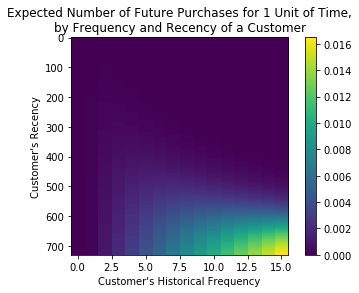

In [31]:
plot_frequency_recency_matrix(bgf);

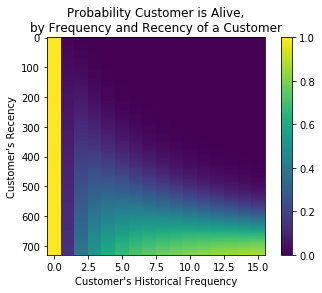

In [25]:
plot_probability_alive_matrix(bgf);

C:\Users\Home Laptop\Anaconda3\lib\site-packages\lifetimes\generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)
C:\Users\Home Laptop\Anaconda3\lib\site-packages\lifetimes\generate_data.py:54: RuntimeWarning: overflow encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


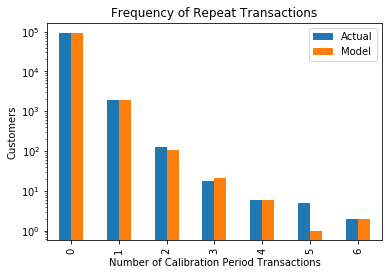

In [26]:
plot_period_transactions(bgf).set_yscale('log');

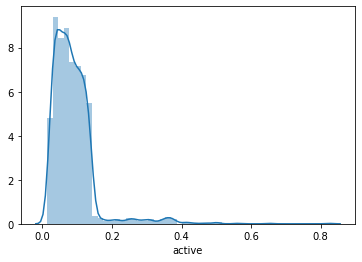

In [51]:
metrics = rfm_summary[rfm_summary['frequency']>0]
metrics['active'] = bgf.conditional_probability_alive(metrics['frequency'],metrics['recency'],metrics['T'])
sns.distplot(metrics['active']);

In [65]:
metrics['active'].sum()

183.52925347015176

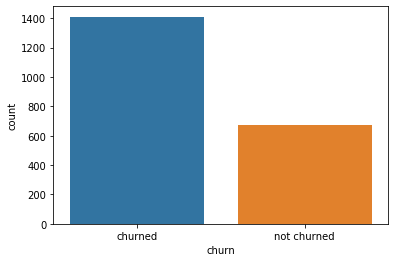

In [52]:
metrics['churn'] = ['churned' if p < .1 else 'not churned' for p in metrics['active']]
sns.countplot(metrics['churn']);

In [53]:
metrics['churn'].value_counts()

churned        1410
not churned     675
Name: churn, dtype: int64

In [58]:
metrics['churn'][(metrics['active']>=.1) & (metrics['active']<.2)] = "high risk"
metrics['churn'].value_counts()

churned        1410
high risk       587
not churned      88
Name: churn, dtype: int64

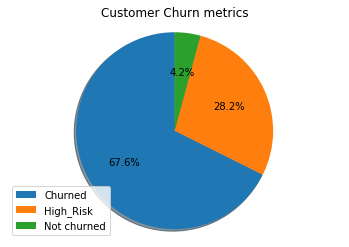

In [66]:
fig1, ax1 = plt.subplots()
data= metrics['churn'].value_counts()

labels= ['Churned', 'High_Risk', 'Not churned']
ax1.pie(data, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Customer Churn metrics')
plt.legend(labels,loc=3)
plt.show()

# Customer lifetime value for 12 months

In [69]:
frequent_cust= rfm_summary[rfm_summary['frequency'] > 0]
print("Number of frequent customers are: ", len(frequent_cust))

Number of frequent customers are:  2085


In [70]:
#trainning gamma gamma model

ggf= GammaGammaFitter(penalizer_coef=0)
ggf.fit(frequent_cust['frequency'], frequent_cust['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2085 subjects, p: 2.98, q: 2.90, v: 72.16>


In [72]:
rfm_summary['CLV'] = round(ggf.customer_lifetime_value(bgf,
                            rfm_summary['frequency'],
                            rfm_summary['recency'],                           
                            rfm_summary['T'],
                            rfm_summary['monetary_value'],
                            time=12,
                            discount_rate=0.1                           
                        ),2)

rfm_summary.sort_values(by='CLV', ascending=False).head(12).reset_index()

,customer_unique_id,frequency,recency,T,monetary_value,CLV
0,4facc2e6fbc2bffab2fea92d2b4aa7e4,3.0,421.0,442.0,512.633333,189.22
1,fe81bb32c243a86b2f86fbf053fe6140,4.0,242.0,316.0,369.850000,184.00
2,8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,476.0,47.642000,157.07
3,397b44d5bb99eabf54ea9c2b41ebb905,3.0,157.0,235.0,280.000000,95.62
4,394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,255.0,106.150000,90.60
5,297ec5afd18366f5ba27520cc4954151,2.0,85.0,199.0,681.220000,85.88
6,6469f99c1f9dfae7733b25662e7f1782,5.0,282.0,349.0,106.880000,79.16
7,dc813062e0fc23409cd255f7f53c7074,5.0,418.0,429.0,75.552000,73.18
8,738ffcf1017b584e9d2684b36e07469c,3.0,246.0,325.0,156.633333,55.74
9,b896655e2083a1d76b7b85df8fc86e40,3.0,284.0,343.0,123.166667,50.12


In [73]:
rfm_summary['CLV'].mean()

1.1089355481030911